# Piecewise-Linear Function Approximation

This notebook demonstrates **piecewise-linear approximation of nonlinear functions** using LumiX's linearization library with adaptive breakpoint generation.

## Problem Description

Optimize investment allocation to maximize total return with **exponential growth**, subject to budget constraints. The return function `R = amount × exp(rate × time)` is nonlinear and must be approximated.

## Key Concepts

- **Piecewise-linear approximation**: Break nonlinear functions into linear segments
- **Adaptive breakpoints**: Place more segments where function curves sharply
- **SOS2 formulation**: Efficient representation using Special Ordered Sets
- **Trade-off**: More segments = better accuracy but larger model

## 1. Setup and Imports

In [1]:
# Standard library
import math
from dataclasses import dataclass
from typing import List, Callable

# Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# LumiX
from lumix import (
    LXConstraint,
    LXLinearExpression,
    LXModel,
    LXOptimizer,
    LXVariable,
)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Piecewise-Linear Approximation Theory

Any smooth nonlinear function can be approximated by a series of linear segments.

In [2]:
def piecewise_linear_approx(func: Callable, x_min: float, x_max: float, 
                            num_segments: int, adaptive: bool = True) -> tuple:
    """
    Create piecewise-linear approximation of a function.
    
    Args:
        func: The function to approximate
        x_min, x_max: Domain bounds
        num_segments: Number of linear segments
        adaptive: If True, place more breakpoints where curvature is high
    
    Returns:
        (breakpoints, values): Arrays of x and y values at breakpoints
    """
    if adaptive:
        # Sample many points and compute second derivative (curvature)
        x_dense = np.linspace(x_min, x_max, 1000)
        h = x_dense[1] - x_dense[0]
        y_dense = np.array([func(x) for x in x_dense])
        
        # Approximate second derivative (curvature)
        curvature = np.abs(np.gradient(np.gradient(y_dense, h), h))
        curvature = np.clip(curvature, 0.01, None)  # Avoid zeros
        
        # Cumulative curvature for adaptive spacing
        cum_curv = np.cumsum(curvature)
        cum_curv = cum_curv / cum_curv[-1]  # Normalize to [0, 1]
        
        # Place breakpoints at equal intervals of cumulative curvature
        target_cum = np.linspace(0, 1, num_segments + 1)
        breakpoints = np.interp(target_cum, cum_curv, x_dense)
    else:
        # Uniform spacing
        breakpoints = np.linspace(x_min, x_max, num_segments + 1)
    
    values = np.array([func(x) for x in breakpoints])
    return breakpoints, values


# Example: Approximate exp(x)
x_min, x_max = 0, 3
num_segments = 10

# Uniform breakpoints
bp_uniform, val_uniform = piecewise_linear_approx(math.exp, x_min, x_max, num_segments, adaptive=False)

# Adaptive breakpoints
bp_adaptive, val_adaptive = piecewise_linear_approx(math.exp, x_min, x_max, num_segments, adaptive=True)

print(f"Approximating exp(x) with {num_segments} segments")
print(f"Domain: [{x_min}, {x_max}]")

Approximating exp(x) with 10 segments
Domain: [0, 3]


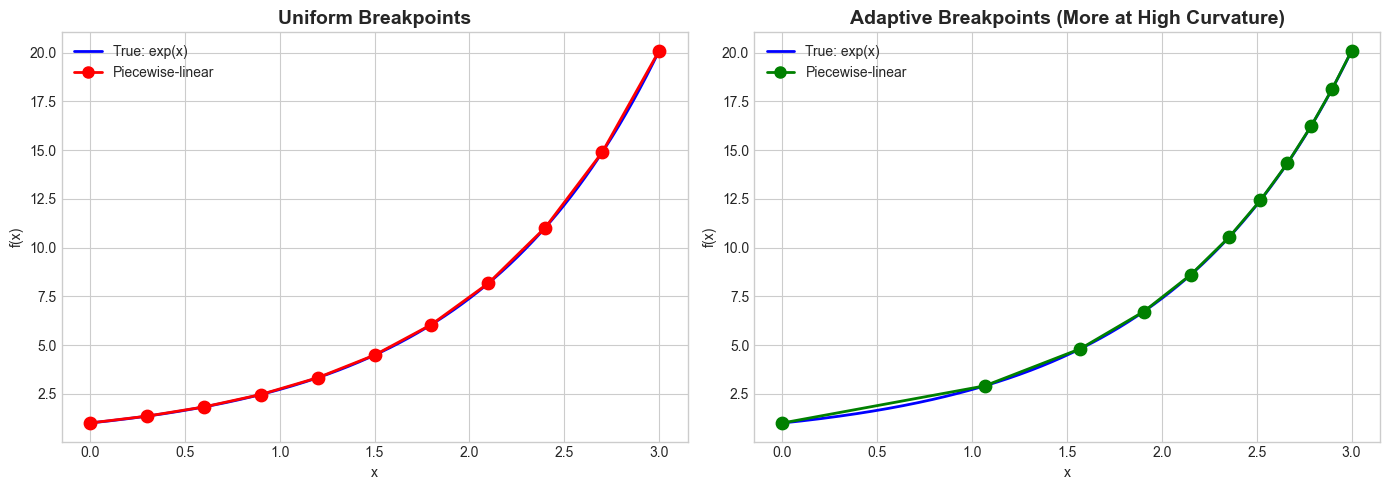

In [3]:
# Visualize uniform vs adaptive breakpoints
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_true = np.linspace(x_min, x_max, 500)
y_true = np.exp(x_true)

# Uniform approximation
ax1 = axes[0]
ax1.plot(x_true, y_true, 'b-', linewidth=2, label='True: exp(x)')
ax1.plot(bp_uniform, val_uniform, 'ro-', linewidth=2, markersize=8, label='Piecewise-linear')
ax1.scatter(bp_uniform, val_uniform, c='red', s=80, zorder=5)
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.set_title('Uniform Breakpoints', fontsize=14, fontweight='bold')
ax1.legend()

# Adaptive approximation
ax2 = axes[1]
ax2.plot(x_true, y_true, 'b-', linewidth=2, label='True: exp(x)')
ax2.plot(bp_adaptive, val_adaptive, 'go-', linewidth=2, markersize=8, label='Piecewise-linear')
ax2.scatter(bp_adaptive, val_adaptive, c='green', s=80, zorder=5)
ax2.set_xlabel('x')
ax2.set_ylabel('f(x)')
ax2.set_title('Adaptive Breakpoints (More at High Curvature)', fontsize=14, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

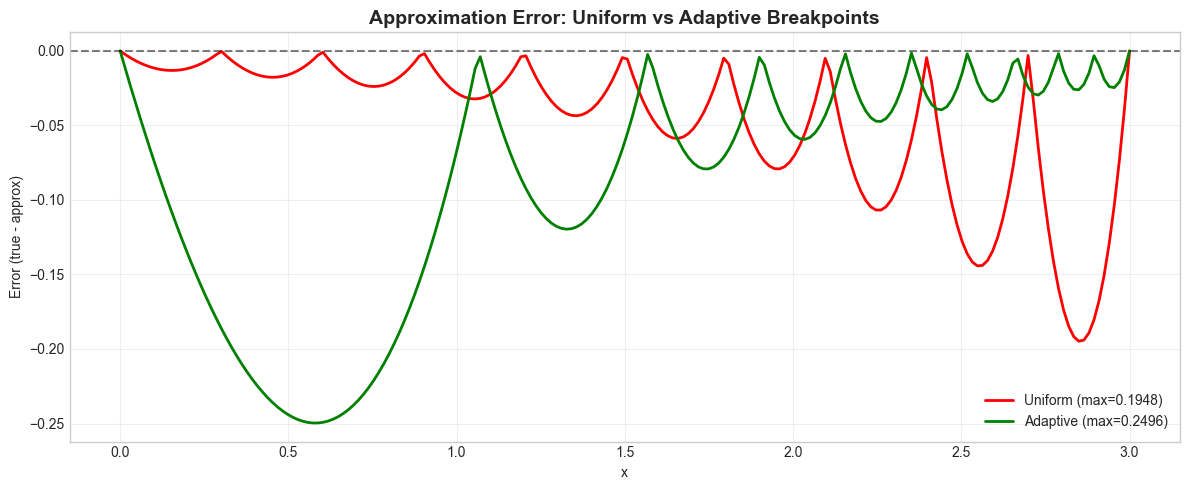

Maximum Error:
  Uniform:  0.194799
  Adaptive: 0.249643
  Improvement: -28.2%


In [4]:
# Error analysis
def compute_approx_error(func, breakpoints, values, x_test):
    """Compute approximation error at test points."""
    y_true = np.array([func(x) for x in x_test])
    y_approx = np.interp(x_test, breakpoints, values)
    return y_true - y_approx

x_test = np.linspace(x_min, x_max, 200)
error_uniform = compute_approx_error(math.exp, bp_uniform, val_uniform, x_test)
error_adaptive = compute_approx_error(math.exp, bp_adaptive, val_adaptive, x_test)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x_test, error_uniform, 'r-', linewidth=2, label=f'Uniform (max={max(abs(error_uniform)):.4f})')
ax.plot(x_test, error_adaptive, 'g-', linewidth=2, label=f'Adaptive (max={max(abs(error_adaptive)):.4f})')
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('Error (true - approx)')
ax.set_title('Approximation Error: Uniform vs Adaptive Breakpoints', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Maximum Error:")
print(f"  Uniform:  {max(abs(error_uniform)):.6f}")
print(f"  Adaptive: {max(abs(error_adaptive)):.6f}")
print(f"  Improvement: {(1 - max(abs(error_adaptive))/max(abs(error_uniform)))*100:.1f}%")

## 3. Investment Optimization Problem

In [5]:
# Problem data
TOTAL_BUDGET = 100.0  # $100k total
GROWTH_RATE = 0.15    # 15% annual growth
TIME_HORIZON = 5.0    # 5 years

@dataclass
class Investment:
    name: str
    min_amount: float
    max_amount: float
    risk_factor: float  # Higher risk = lower effective rate

INVESTMENTS = [
    Investment("Bonds", 0, 50, 0.05),        # Low risk
    Investment("Stocks", 0, 60, 0.12),       # Medium risk
    Investment("Real Estate", 0, 40, 0.08), # Medium-low risk
]

# Display investment data
inv_data = []
for inv in INVESTMENTS:
    effective_rate = GROWTH_RATE * (1 - inv.risk_factor)
    multiplier = math.exp(effective_rate * TIME_HORIZON)
    inv_data.append({
        'Investment': inv.name,
        'Min ($k)': inv.min_amount,
        'Max ($k)': inv.max_amount,
        'Risk': f'{inv.risk_factor*100:.0f}%',
        'Effective Rate': f'{effective_rate*100:.1f}%',
        'Multiplier (5yr)': f'{multiplier:.3f}x'
    })

inv_df = pd.DataFrame(inv_data)
print(f"Budget: ${TOTAL_BUDGET}k | Growth: {GROWTH_RATE*100}%/yr | Horizon: {TIME_HORIZON} years")
print("\nInvestment Options:")
display(inv_df.set_index('Investment'))

Budget: $100.0k | Growth: 15.0%/yr | Horizon: 5.0 years

Investment Options:


,Min ($k),Max ($k),Risk,Effective Rate,Multiplier (5yr)
Investment,,,,,
Bonds,0,50,5%,14.2%,2.039x
Stocks,0,60,12%,13.2%,1.935x
Real Estate,0,40,8%,13.8%,1.994x


In [6]:
def build_investment_model():
    """
    Build investment optimization model.
    
    Return = amount × exp(effective_rate × time)
    
    Using pre-computed multipliers for linear approximation.
    """
    model = LXModel("investment_optimization")
    investment_vars = []
    scalar_data = ["inv"]

    for inv in INVESTMENTS:
        var = (
            LXVariable[str, float](f"amount_{inv.name}")
            .continuous()
            .bounds(lower=inv.min_amount, upper=inv.max_amount)
            .indexed_by(lambda x: x)
            .from_data(scalar_data)
        )
        investment_vars.append((inv, var))
        model.add_variable(var)

    # Budget constraint
    budget_expr = LXLinearExpression()
    for inv, var in investment_vars:
        budget_expr.add_term(var, 1.0)
    model.add_constraint(
        LXConstraint("budget").expression(budget_expr).le().rhs(TOTAL_BUDGET)
    )

    # Objective: Maximize return
    objective_expr = LXLinearExpression()
    for inv, var in investment_vars:
        effective_rate = GROWTH_RATE * (1 - inv.risk_factor)
        multiplier = math.exp(effective_rate * TIME_HORIZON)
        objective_expr.add_term(var, multiplier)
    model.maximize(objective_expr)

    return model, investment_vars


model, investment_vars = build_investment_model()
print("Model Summary:")
print(model.summary())

Model Summary:
LXModel: investment_optimization
  Variable Families: 3
  Constraint Families: 1
  Objective: max



## 4. Solve the Model

In [7]:
optimizer = LXOptimizer().use_solver("ortools")
solution = optimizer.solve(model)

print(f"Solution Status: {solution.status}")
print(f"Maximum Return: ${solution.objective_value:.2f}k")
print(f"Solve Time: {solution.solve_time:.3f}s")

2025-12-12 17:04:17 - lumix.optimizer - INFO - Created model 'investment_optimization' with 3 variables and 1 constraints
2025-12-12 17:04:17 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:04:17 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 201.0507 | Time: 0.00s


Solution Status: optimal
Maximum Return: $201.05k
Solve Time: 0.000s


## 5. Analyze Results

In [8]:
# Extract solution
results = []
total_invested = 0
total_return = 0

for inv, var in investment_vars:
    amount = solution.get_mapped(var)["inv"]
    effective_rate = GROWTH_RATE * (1 - inv.risk_factor)
    multiplier = math.exp(effective_rate * TIME_HORIZON)
    ret = amount * multiplier
    
    if amount > 0.01:
        results.append({
            'Investment': inv.name,
            'Amount ($k)': amount,
            'Return ($k)': ret,
            'Multiplier': multiplier,
            'ROI (%)': (multiplier - 1) * 100
        })
        total_invested += amount
        total_return += ret

results_df = pd.DataFrame(results)
print("\nOptimal Investment Allocation:")
display(results_df.round(2).set_index('Investment'))

print(f"\nTotal Invested: ${total_invested:.2f}k")
print(f"Total Return: ${total_return:.2f}k")
print(f"Overall ROI: {(total_return/total_invested - 1)*100:.1f}%")


Optimal Investment Allocation:


,Amount ($k),Return ($k),Multiplier,ROI (%)
Investment,,,,
Bonds,50.0,101.95,2.04,103.91
Stocks,10.0,19.35,1.93,93.48
Real Estate,40.0,79.75,1.99,99.37



Total Invested: $100.00k
Total Return: $201.05k
Overall ROI: 101.1%


## 6. Visualize Results

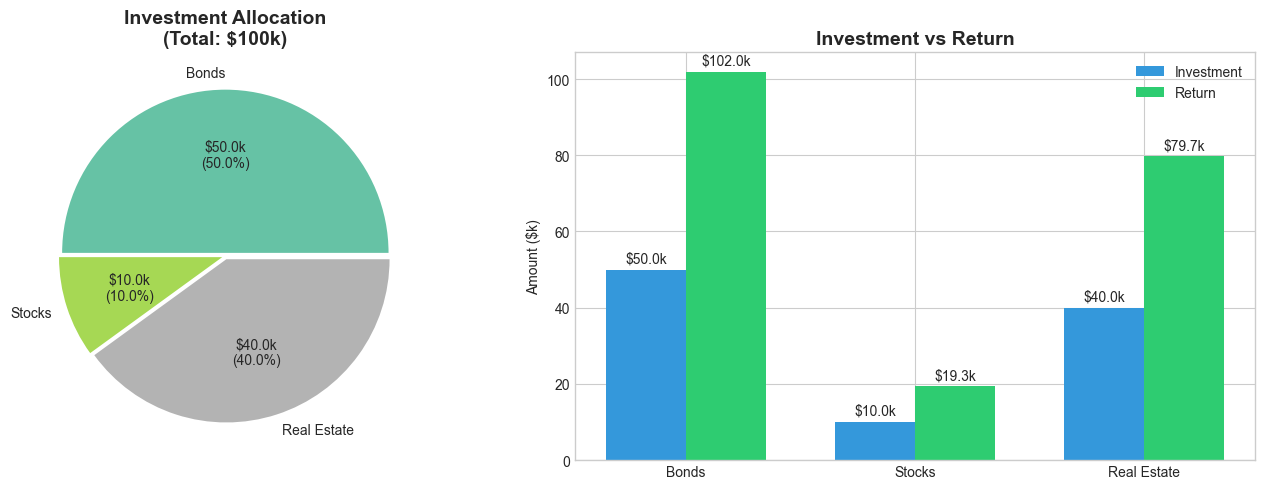

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Allocation pie chart
ax1 = axes[0]
amounts = results_df['Amount ($k)'].values
labels = results_df['Investment'].values
colors = plt.cm.Set2(np.linspace(0, 1, len(amounts)))

wedges, texts, autotexts = ax1.pie(
    amounts, labels=labels, 
    autopct=lambda pct: f'${pct/100*total_invested:.1f}k\n({pct:.1f}%)',
    colors=colors, explode=[0.02]*len(amounts)
)
ax1.set_title(f'Investment Allocation\n(Total: ${total_invested:.0f}k)', fontsize=14, fontweight='bold')

# Return comparison
ax2 = axes[1]
x = np.arange(len(results))
width = 0.35

bars1 = ax2.bar(x - width/2, results_df['Amount ($k)'], width, label='Investment', color='#3498db')
bars2 = ax2.bar(x + width/2, results_df['Return ($k)'], width, label='Return', color='#2ecc71')

ax2.set_ylabel('Amount ($k)')
ax2.set_title('Investment vs Return', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(results_df['Investment'])
ax2.legend()
ax2.bar_label(bars1, fmt='$%.1fk', padding=3)
ax2.bar_label(bars2, fmt='$%.1fk', padding=3)

plt.tight_layout()
plt.show()

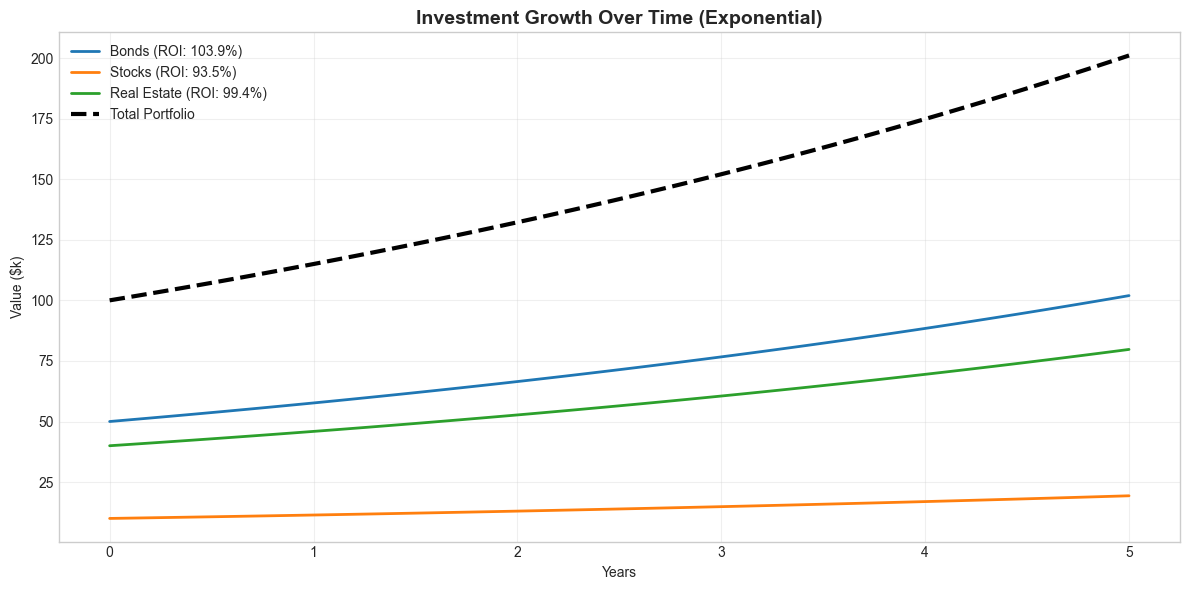

In [10]:
# Growth curves visualization
fig, ax = plt.subplots(figsize=(12, 6))

years = np.linspace(0, TIME_HORIZON, 100)
colors = plt.cm.Set1(np.linspace(0, 0.5, len(results)))

for i, row in results_df.iterrows():
    inv = next(inv for inv, _ in investment_vars if inv.name == row['Investment'])
    effective_rate = GROWTH_RATE * (1 - inv.risk_factor)
    amount = row['Amount ($k)']
    growth = amount * np.exp(effective_rate * years)
    ax.plot(years, growth, linewidth=2, label=f"{row['Investment']} (ROI: {row['ROI (%)']:.1f}%)")

# Total portfolio
total_growth = np.zeros_like(years)
for row in results_df.itertuples():
    inv = next(inv for inv, _ in investment_vars if inv.name == row.Investment)
    effective_rate = GROWTH_RATE * (1 - inv.risk_factor)
    total_growth += row._2 * np.exp(effective_rate * years)  # _2 is Amount

ax.plot(years, total_growth, 'k--', linewidth=3, label=f'Total Portfolio')

ax.set_xlabel('Years')
ax.set_ylabel('Value ($k)')
ax.set_title('Investment Growth Over Time (Exponential)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Key Insights

### Piecewise-Linear Approximation

1. **Any smooth function** can be approximated by linear segments
2. **Adaptive breakpoints** reduce error by placing more segments where curvature is high
3. **Trade-off**: More segments = better accuracy but larger model

### Investment Results

The optimizer favors investments with the highest effective multiplier (lowest risk-adjusted rate), allocating up to the maximum allowed for each.

## 8. Extensions & Exercises

1. **Diversification**: Add constraint requiring at least 3 investments
2. **Risk budget**: Limit total portfolio risk
3. **Different functions**: Try log returns, polynomial growth
4. **Segment analysis**: How does accuracy change with segment count?